In [1]:
import numpy as np
import math
import cvxpy
import matplotlib.pyplot as plt
import cubic_spline_planner
from tqdm import tqdm

In [2]:
x1 = np.linspace(5, 43, 6)
x2 = np.repeat(42.5, 3) + np.random.normal(0, 0.75, 3)
x2 = np.clip(x2, 41, 44)

y1 = np.repeat(3, 6) + np.random.normal(0, 0.75, 6)
y1 = np.clip(y1, 2, 4)

y2 = np.linspace(7.5, 17.5, 3)

x_point = np.r_[1, x1, x2, 42.5]
y_point  = np.r_[3, y1, y2, 20]

In [3]:
cx, cy, cyaw, ck, s = cubic_spline_planner.calc_spline_course(x_point, y_point, ds=0.1)

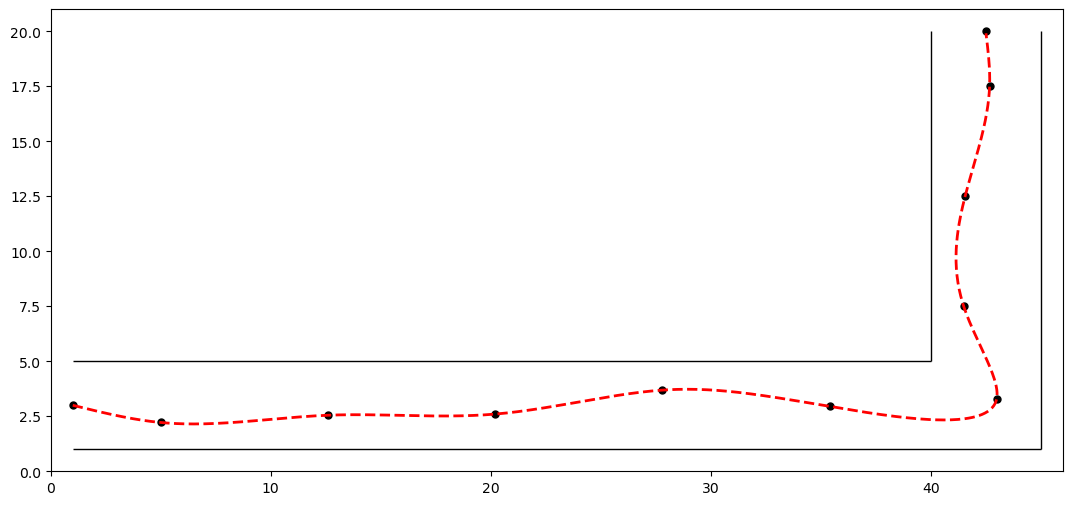

In [4]:
# Plot target points and car trajectory
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

ax.plot(x_point, y_point, 'k.', markersize=10)
ax.plot(cx, cy, 'r--', linewidth=2)

ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

ax.set_xlim(0, 46)
ax.set_ylim(0, 21)
ax.set_aspect('equal')


plt.show()

In [5]:
# Reload package
import importlib
import MPC
importlib.reload(MPC)
from MPC import *
from tqdm.autonotebook import tqdm

In [13]:
initial_state = Vehicle(x=cx[0], y=cy[0], yaw=cyaw[0], v=0.0)

dl = 2.0
simulation = Simulation(initial_state)

t, x, y, yaw, v, d, a, target_inds, xrefs = simulation.simulate(cx, cy, cyaw, ck, dl)

MPC: 400it [00:48,  8.25it/s, x=42.5, y=19.9, d=0.0211, v=0.0102]

Goal


In [8]:
dx = np.empty_like(x)
dy = np.empty_like(y)

for i in range(len(x)):
    dx[i] = v[i] * math.cos(yaw[i]) * initial_state.dt
    dy[i] = v[i] * math.sin(yaw[i]) * initial_state.dt

In [21]:
cy[target_inds[i]]

19.910057973675563

  0%|          | 0/401 [00:00<?, ?it/s]

MovieWriter Pillow unavailable; using Pillow instead.


IndexError: list index out of range

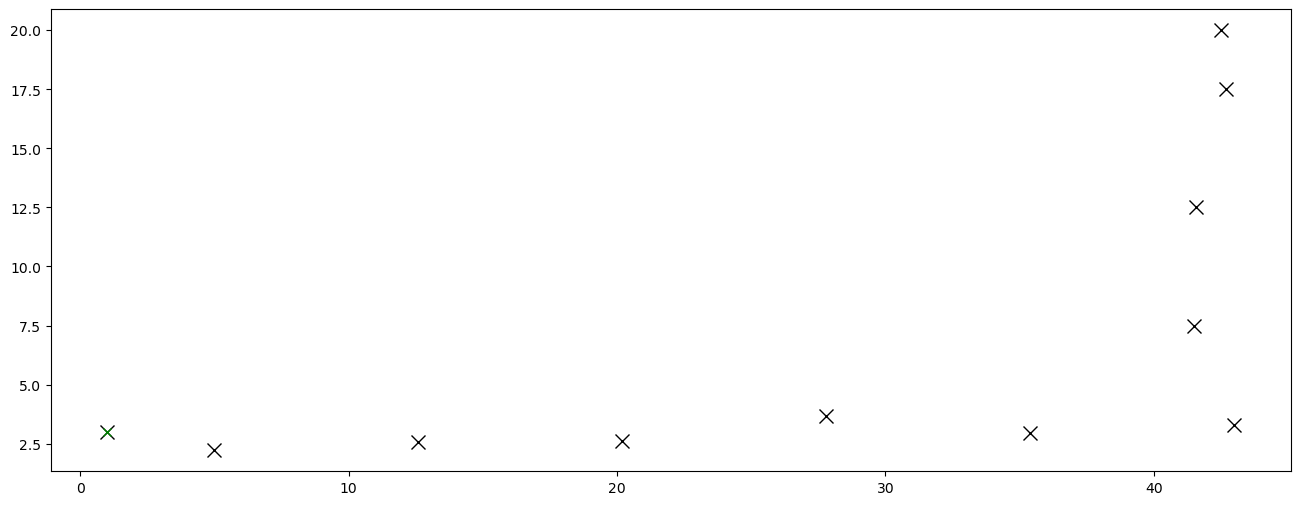

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

def animate(i):
    ax.cla()
    #ax.plot(cx, cy, "-r", label="course")
    ax.plot(x_point, y_point, "kx", markersize=10)
    ax.plot(x[:i], y[:i], "-b", label="trajectory")
    #ax.plot(xrefs[i, 0, :], xrefs[i, 1, :], "xk", label="xref")
    ax.plot(cx[target_inds[i]], cy[target_inds[i]], "xg", label="target")
    plot_car(ax, x[i], y[i], yaw[i], steer=d[i], cabcolor="k", truckcolor="k")
    ax.axis("equal")
    ax.grid(True)
    ax.set_title("Time[s]:" + str(round(t[i], 2)) + ", speed[km/h]:" + str(round(v[i] * 3.6, 2)))
    ax.hlines(1, 1, 45, color='k', linestyle='solid', linewidth=1)
    ax.hlines(5, 1, 40, color='k', linestyle='solid', linewidth=1)
    ax.vlines(45, 1, 20, color='k', linestyle='solid', linewidth=1)
    ax.vlines(40, 5, 20, color='k', linestyle='solid', linewidth=1)

    ax.set_xlim(0, 46)
    ax.set_ylim(0, 21)
    ax.set_aspect('equal')

ani = animation.FuncAnimation(fig, animate, frames=len(t), repeat=False)

# Save animation with progress bar
with tqdm(total=len(t)) as pbar:
    ani.save('animation.gif', writer='Pillow', fps=25, progress_callback=lambda i, n: pbar.update())
    
plt.close()